In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

In [2]:
import os
from ppe_tools import Ensemble,Member,ParamInfo
from ppe_tools.utils import get_default, parse_val

In [3]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:30:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35440 instead
  http_address["port"], self.http_server.port


In [10]:
client

Client Scheduler: tcp://10.12.206.63:39084 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 20 Cores: 20 Memory: 500.00 GB


In [7]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        m      = paramkey.minmax[ix].values[0]
        if 'min' in m:
            minmaxs.append('min')
        elif 'max' in m:
            minmaxs.append('max')
        else:
            minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [8]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0' or htape=='h1':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug

    #specify extra variables    
    if htape=='h0':
        extras     = ['grid1d_lat','grid1d_lon']
    elif htape=='h1':
        extras     = ['pfts1d_lat','pfts1d_lon','pfts1d_wtgcell','pfts1d_itype_veg']
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

In [37]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

## look at the original CTL,AF1855, and C285 ensembles

In [38]:
envs = ['CTL2010','AF1855','C285']
topdir = '/glade/scratch/djk2120/PPEn11/hist/'

for env in envs:
    files = sorted(glob.glob(topdir+env+'/*h0*'))
    thiskeys  = [file.split('_')[2].split('.')[0] for file in files]
    if env=='CTL2010':
        keys = set(thiskeys)
    keys = keys&set(thiskeys)
    
keys = sorted(list(keys))       

In [58]:
dsets = []
for env in envs:
    ds = get_ensemble(env,data_vars,'h1',keys,paramkey)
    ds['pft']=ds.pfts1d_itype_veg
    dsets.append(ds)

In [75]:
lai_thresh  = 0.1
surv_thresh = 0.7
survs = []
for i in range(3):
    npix = (dsets[i].TLAI.max(dim='time')>lai_thresh).groupby('pft').sum().compute()
    surv = (npix/npix.isel(ens=0)).compute().isel(pft=np.arange(17)>0)>surv_thresh
    survs.append(surv)
    if i==0:
        surv3 = surv.values
    else:
        surv3 = surv3*surv.values
surv  = xr.DataArray(surv3,dims=['ens','pft'],name='survived')
sflag = surv.sum(dim='pft')==16

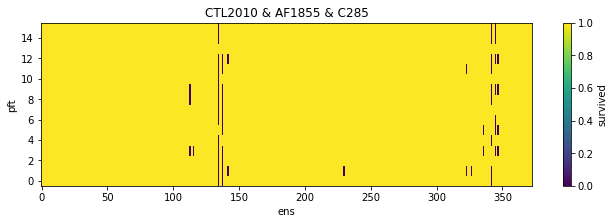

In [82]:
plt.figure(figsize=[11,3])
surv.T.plot()
plt.title('CTL2010 & AF1855 & C285');

### create new paramfiles to contrain ranges
 - submitting three more per dead member (to save time)
 - it happened to be that no namelist params died
     - so this will break if trying to constrain namelist params

In [156]:
#instantiate the Ensemble object
basefile = '/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc'
lndin    = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
pdir     = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir     = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
surv2    = Ensemble(basefile,pdir,ndir)


defp = xr.open_dataset(pdir+'OAAT0000.nc')
ot = 1+np.arange(16)
ds = dsets[0]
nextk = 400
kvals=[];pvals=[];mvals=[]

for w1,howmany in zip([0.5,0.25,0.125],[2,3,4]):
    w0 = 1-w1
    for i,k in zip(ds.ens.values, ds.key.values):
        if not sflag.isel(ens=i):
            p=ds.param.isel(ens=i).values.ravel()[0]
            m=ds.minmax.isel(ens=i).values.ravel()[0]

            p0 = defp[p]
            p1 = xr.open_dataset(pdir+k+'.nc')[p]

            if p1.shape: #param has pft dimension                    
                ix = ot[~surv.isel(ens=i).values] #which pfts died?
                #constrain dead pfts
                newp = p1.copy(deep=True)
                newp[ix] = w0*p0[ix]+w1*p1[ix] 
            else: #param is scalar
                newp = w0*p0+w1*p1
                
            loc    = 'P'
            defval = get_default(p, loc, defp, lndin)
            value  = parse_val(loc,defval,newp)
            minmax = m+str(howmany)
            key    = 'OAAT'+str(nextk).zfill(4)
            
            paraminfo = ParamInfo(p, loc, defval, value)
            paramdict = {p:paraminfo}
            member    = Member(key,paramdict,basefile,minmax)   
            surv2.add_member(member)
            
            kvals.append(key)
            pvals.append(p)
            mvals.append(minmax)
            
            nextk+=1
            
surv2.write()
newcsv=pd.DataFrame({'key':kvals,'param':pvals,'minmax':mvals})
newcsv.to_csv('/glade/scratch/djk2120/PPEn11/surv_resubmit.csv',index=False)

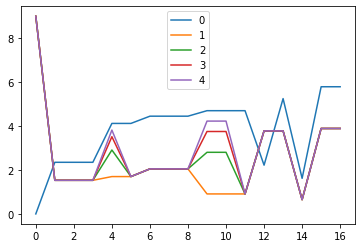

In [179]:
#spot check a pft variable
pk = pd.read_csv('/glade/scratch/djk2120/PPEn11/surv_resubmit.csv')
thisp = 'medlynslope'
plt.plot(defp[thisp][:17])
p1 = xr.open_dataset(pdir+'OAAT0117.nc')[thisp]

plt.plot(p1[:17])
for p,k in zip(pk.param.values,pk.key.values):
    if p==thisp:
        newp = xr.open_dataset(pdir+k+'.nc')[p]
        plt.plot(newp[:17])
plt.legend(range(5));

In [198]:
#spot check the non-pft param
print('          original perturbation -----> default value')
parms = list(np.unique(pk.param.values))
parms.remove('medlynslope')
parms.remove('medlynintercept')
for parm in parms:
    ix = pk.param==parm
    mm = pk.minmax[ix].values[0][:3]
    ix = np.logical_and(ds.param==parm,ds.minmax==mm)
    k1 = ds.key.isel(ens=ix).values[0]
    p1 = xr.open_dataset(pdir+k1+'.nc')[parm]
    
    thisstr = parm+': '+str(p1.values)
    ix = pk.param==parm
    for key in pk.key[ix]:        
        newp = xr.open_dataset(pdir+key+'.nc')[parm]
        thisstr = thisstr+', '+str(newp.values)
    thisstr = thisstr+', '+str(defp[parm].values)    
    
    print(thisstr)
    

          original perturbation -----> default value
jmaxb0: 0.01, 0.02055, 0.025824999999999997, 0.0284625, 0.0311
jmaxse_sf: 1.2, 1.1, 1.05, 1.025, 1.0
lmrhd: 75325.0, 112987.5, 131818.75, 141234.375, 150650.0
lmrse: 588.0, 539.0, 514.5, 502.25, 490.0
q10_mr: 1.0, 1.25, 1.375, 1.4375, 1.5
tpuha: 173000.0, 122500.0, 97250.0, 84625.0, 72000.0
vcmaxha: 173000.0, 122500.0, 97250.0, 84625.0, 72000.0
vcmaxhd: 90000.0, 145000.0, 172500.0, 186250.0, 200000.0
vcmaxse_sf: 1.2, 1.1, 1.05, 1.025, 1.0
wc2wjb0: 0.5, 0.6527000000000001, 0.72905, 0.767225, 0.8054


In [57]:
x = [75325.0, 112987.5, 131818.75, 141234.375, 150650.0]
np.array(x)/150650

array([0.5   , 0.75  , 0.875 , 0.9375, 1.    ])

### second round of resubmissions
- I handled medlynintercept separately, in the next section

In [35]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/full.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [40]:
ix = paramkey.param=='medlynintercept'
paramkey.minmax[ix]

115    min
116    max
Name: minmax, dtype: object

In [42]:
envs = ['CTL2010','C285','AF1855']
datavars=['TLAI']
dsets = []
for env in envs:
    ds = get_ensemble(env,datavars,'h1',paramkey.key,paramkey)
    ds['pft']=ds.pfts1d_itype_veg
    dsets.append(ds)

In [44]:
lai_thresh  = 0.1
surv_thresh = 0.7
survs = []
for i in range(3):
    npix = (dsets[i].TLAI.max(dim='time')>lai_thresh).groupby('pft').sum().compute()
    surv = (npix/npix.isel(ens=0)).compute().isel(pft=np.arange(17)>0)>surv_thresh
    survs.append(surv)
    if i==0:
        surv3 = surv.values
    else:
        surv3 = surv3*surv.values
surv  = xr.DataArray(surv3,dims=['ens','pft'],name='survived')
sflag = surv.sum(dim='pft')==16

In [59]:
uniques = []
for p,m in zip(ds.param.values,ds.minmax.values):
    ustr = p+'-'+m
    if ustr not in uniques:
        uniques.append(ustr)

In [60]:
#which params still need resubmission?
for u in uniques:
    p = u.split('-')[0]
    m = u.split('-')[1]
    ix = (ds.param==p) & (ds.minmax==m)
    if True not in sflag.isel(ens=ix):
        print(u)

medlynintercept-max
vcmaxhd-min
lmrhd-min
vcmaxse_sf-max


In [80]:
#create a paramkey with only the first good surviving key
goodkeys=[]
goodps  =[]
goodms  =[]
for u in uniques:
    p = u.split('-')[0]
    m = u.split('-')[1]
    ix = (ds.param==p) & (ds.minmax==m)
    s = sflag[ix]
    if True in s:
        firstk = str(ds.key[ix][s][0].values)  #take the first key where sflag is true
        goodkeys.append(firstk)
        goodps.append(p)
        goodms.append(m)
        
ranks = np.argsort(goodkeys)
goodkeys = [goodkeys[rank] for rank in ranks]
goodps   = [goodps[rank] for rank in ranks]
goodms   = [goodms[rank] for rank in ranks]

survkey = pd.DataFrame({'key':goodkeys,'param':goodps,'minmax':goodms})
survkey.to_csv('/glade/scratch/djk2120/PPEn11/surv.csv',index=False)


In [104]:

nextk

439

In [114]:
constrains=['vcmaxhd-min','lmrhd-min','vcmaxse_sf-max']
nextk = int(sorted(glob.glob('/glade/scratch/djk2120/PPEn11/paramfiles/OAAT*.nc'))[-1].split('/')[-1].split('.')[0][4:])+1

#instantiate the Ensemble object
basefile = '/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc'
lndin    = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
pdir     = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir     = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
surv3    = Ensemble(basefile,pdir,ndir)

f = open('/glade/scratch/djk2120/PPEn11/surv_resubmit2.csv', "a")
f.write('key,param,minmax\n')


defp = xr.open_dataset(pdir+'OAAT0000.nc')

for w1,howmany in zip([0.5,0.25,0.125],[5,6,7]):
    w0 = 1-w1

    for u in constrains:
        p = u.split('-')[0]
        m = u.split('-')[1]
        ix = (ds.param==p) & (ds.minmax==m)
        k = str(ds.key[ix][-1].values)
        
        p0 = defp[p]
        p1 = xr.open_dataset(pdir+k+'.nc')[p]
        newp = w0*p0+w1*p1
        
        
        loc    = 'P'
        defval = get_default(p, loc, defp, lndin)
        value  = parse_val(loc,defval,newp)
        minmax = m+str(howmany)
        key    = 'OAAT'+str(nextk).zfill(4)

        paraminfo = ParamInfo(p, loc, defval, value)
        paramdict = {p:paraminfo}
        member    = Member(key,paramdict,basefile,minmax)   
        
        
        surv3.add_member(member)
        
        f.write(key+','+p+','+minmax+'\n')
        nextk+=1
      
f.close()

In [116]:
surv3.write()


### investigate medlynintercept
 - can lead to global negative FCEV

In [ ]:
datavars = ['FCEV']
envs = ['CTL2010','C285','AF1855']
fcevs=[]
for env in envs:
    ds = get_ensemble(env,datavars,'h0',paramkey.key,paramkey)
    fcevs.append(ds)

In [117]:
ds = fcevs[0]
p = 'medlynintercept'
m = 'max'
ix = np.logical_and(ds.param==p,ds.minmax==mm)
ix = np.logical_or(ix,ds.param=='default')

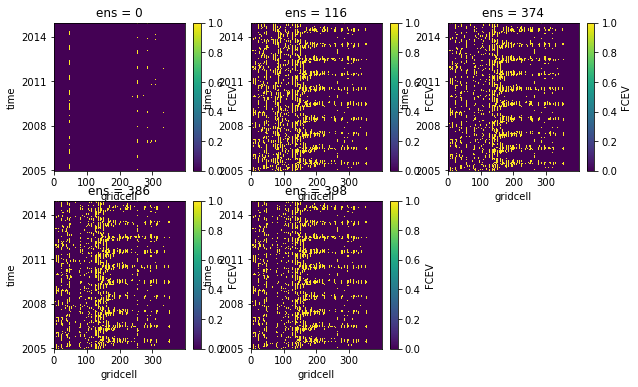

In [131]:
plt.figure(figsize=[10,6])
for i in range(5):
    plt.subplot(2,3,i+1)
    fcev_neg = ds.FCEV.isel(ens=ix).isel(ens=i)<-5
    fcev_neg.plot()

In [125]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [130]:
cf = 1/la.sum()/365
fcev_glob = cf*(month_wts(10)*(la*ds.FCEV.isel(ens=ix)).sum(dim='gridcell')).groupby('time.year').sum().mean(dim='year').compute()
fcev_glob

<xarray.DataArray (ens: 5)>
array([ 6.91307479, -3.0899688 , -0.45593577,  0.2581948 ,  0.55221849])
Coordinates:
  * ens      (ens) int64 0 116 374 386 398

In [143]:
medkeys = ds.key[ix].values
for key in medkeys:
    pdir = '/glade/scratch/djk2120/PPEn11/paramfiles/'
    f = pdir+key+'.nc'
    p = xr.open_dataset(f)['medlynintercept']
    m = np.mean(p[1:17]).values
    print(key,m)

OAAT0000 100.0
OAAT0120 200000.0
OAAT0401 193753.125
OAAT0413 190629.6875
OAAT0425 189067.96875


### I think we should redo medlynintercept constraining all pfts at once

In [24]:
kvals = [401,413,425,436,437,438]
mvals = 100000/(2**np.arange(6))
iters = [2,3,4,5,6,7]

#instantiate the Ensemble object
basefile = '/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc'
lndin    = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
pdir     = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir     = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
medg0    = Ensemble(basefile,pdir,ndir)

for mval,kval,howmany in zip(mvals,kvals,iters):

    defp = xr.open_dataset(pdir+'OAAT0000.nc')
    p = 'medlynintercept'
    p0 = defp[p]
    newp = p0.copy(deep=True)
    newp[:] = mval


    loc    = 'P'
    defval = get_default(p, loc, defp, lndin)
    value  = parse_val(loc,defval,newp)
    minmax = 'max'+str(howmany)
    key    = 'OAAT'+str(kval).zfill(4)

    paraminfo = ParamInfo(p, loc, defval, value)
    paramdict = {p:paraminfo}
    member    = Member(key,paramdict,basefile,minmax)   
    medg0.add_member(member)

In [26]:
medg0.write()

In [34]:
pp = xr.open_dataset('/glade/scratch/djk2120/PPEn11/paramfiles/OAAT0401.nc')['medlynintercept']
pp

<xarray.DataArray 'medlynintercept' (pft: 79)>
array([100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000., 100000.,
       100000., 100000., 100000., 100000., 100000., 100000., 100000.])
Coordinates:
    pftname  (pft) |S40 ...
Dimensions without coordinates: pft
Attributes:
    long_name:  Medlyn intercept of conductance-photosynthesis relationship
    units:      umol H2O

In [96]:
u  = 'medlynintercept'
mm = 'max'
ix = np.logical_and(ds.param==u,ds.minmax==mm)
ix = np.logical_or(ix,ds.param=='default')
npixs = []
survs = []
for ds in dsets:
    npix = (ds.TLAI.isel(ens=ix).max(dim='time')>lai_thresh).groupby('pft').sum().compute()
    npixs.append(npix)
    surv = (npix/npix.isel(ens=0)).compute().isel(pft=np.arange(17)>0)>surv_thresh
    survs.append(surv)

In [97]:
surv

<xarray.DataArray 'TLAI' (ens: 5, pft: 16)>
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]])
Coordinates:
  * ens      (ens) int64 0 116 374 386 398
  * pft      (pft) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 12.0 13.0 14.0 15.0 16.0

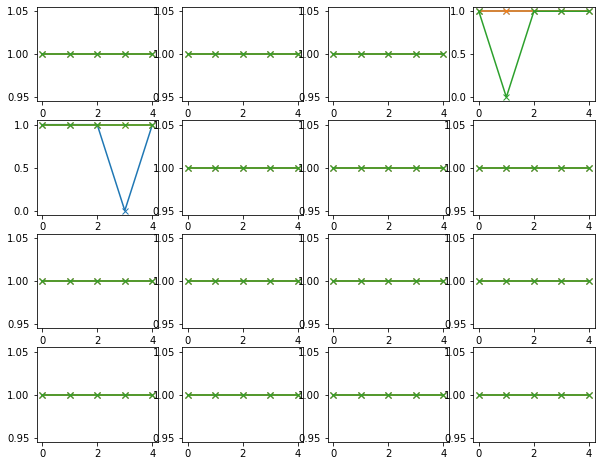

In [100]:
plt.figure(figsize=[10,8])
for i in 1+np.arange(16):
    plt.subplot(4,4,i)
    for j in range(3):
        plt.plot(survs[j].isel(pft=i-1),'-x')

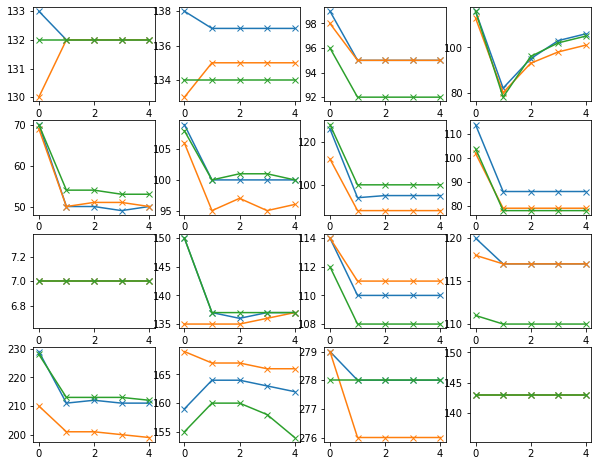

In [102]:
plt.figure(figsize=[10,8])
for i in 1+np.arange(16):
    plt.subplot(4,4,i)
    for j in range(3):
        plt.plot(npixs[j].isel(pft=i),'-x')

### investigate sucsat_sf

In [119]:
ds.key[ds.param=='sucsat_sf']

<xarray.DataArray 'key' (ens: 2)>
array(['OAAT0066', 'OAAT0067'], dtype=object)
Coordinates:
  * ens      (ens) int64 66 67

In [121]:
datavars = ['FCTR','FGEV','QHR']
keys = ['OAAT0000','OAAT0066','OAAT0067']
ds = get_ensemble('CTL2010',datavars,'h0',keys,paramkey)
ds

<xarray.Dataset>
Dimensions:     (ens: 3, gridcell: 400, time: 120)
Coordinates:
  * time        (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    FCTR        (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FGEV        (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    QHR         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    grid1d_lat  (gridcell) float64 ...
    grid1d_lon  (gridcell) float64 ...
    key         (ens) <U8 'OAAT0000' 'OAAT0066' 'OAAT0067'
    param       (ens) <U9 'default' 'sucsat_sf' 'sucsat_sf'
    minmax      (ens) <U7 'default' 'min' 'max'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n08_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn08_CTL2010_PROD_001
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                CTL2010_OAAT0000_postSASUresta...
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:                          71
    ctype_urban_sunwall:                       72
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn08_CTL2010_PROD_001.clm2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

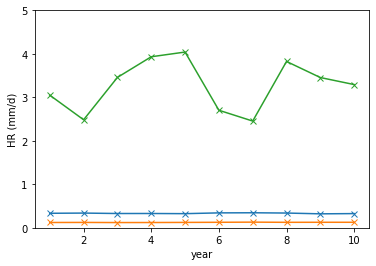

In [133]:
cf = 24*60*60/la.sum()/365
qhr = cf*(month_wts(10)*(la*ds.QHR).sum(dim='gridcell')).groupby('time.year').sum()
plt.plot(1+np.arange(10),-qhr,'-x')
plt.ylim([0,5])
plt.ylabel('HR (mm/d)')
plt.xlabel('year');

In [157]:
sucsat_high = 1+8/2**np.arange(6)[1:]
sucsat_low = 1/sucsat_high
svals = [*sucsat_high,*sucsat_low]
iters = 2+np.arange(5)
iters = [*iters,*iters]

nextk = int(sorted(glob.glob('/glade/scratch/djk2120/PPEn11/paramfiles/OAAT*.nc'))[-1].split('/')[-1].split('.')[0][4:])+1
#instantiate the Ensemble object
basefile = '/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc'
lndin    = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
pdir     = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir     = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
scsat    = Ensemble(basefile,pdir,ndir)

for sval,howmany in zip(svals,iters):

    if sval>1:
        m='max'
    else:
        m='min'
    
    defp = xr.open_dataset(pdir+'OAAT0000.nc')
    p = 'sucsat_sf'
    p0 = defp[p]
    newp = p0.copy(deep=True)
    newp = sval


    loc    = 'P'
    defval = get_default(p, loc, defp, lndin)
    value  = parse_val(loc,defval,newp)
    minmax = m+str(howmany)
    key    = 'OAAT'+str(nextk).zfill(4)

    paraminfo = ParamInfo(p, loc, defval, value)
    paramdict = {p:paraminfo}
    member    = Member(key,paramdict,basefile,minmax)   
    scsat.add_member(member)
    
    nextk+=1

In [161]:
scsat.write(csvfile='/glade/scratch/djk2120/PPEn11/sucsat.csv')

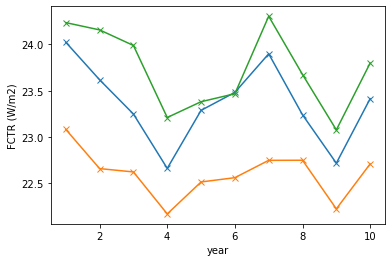

In [135]:
cf = 1/la.sum()/365
fctr = cf*(month_wts(10)*(la*ds.FCTR).sum(dim='gridcell')).groupby('time.year').sum()
plt.plot(1+np.arange(10),fctr,'-x')
#plt.ylim([0,5])
plt.ylabel('FCTR (W/m2)')
plt.xlabel('year');

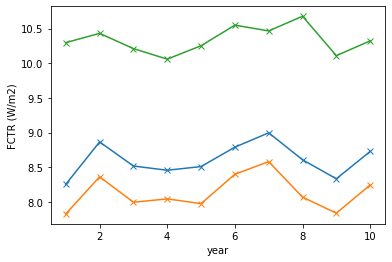

In [136]:
cf = 1/la.sum()/365
fgev = cf*(month_wts(10)*(la*ds.FGEV).sum(dim='gridcell')).groupby('time.year').sum()
plt.plot(1+np.arange(10),fgev,'-x')
#plt.ylim([0,5])
plt.ylabel('FCTR (W/m2)')
plt.xlabel('year');

## deprecated

In [11]:
env = 'CTL2010'
thedir = '/glade/scratch/djk2120/PPEn11/hist/'+env+'/'
laithresh = 0.1
files = sorted(glob.glob(thedir+'*h1*nc'))
keys  = [file.split('_')[2].split('.')[0] for file in files]

In [12]:
ctl    = get_ensemble('CTL2010',['TLAI','GPP'],'h1',paramkey)
c285   = get_ensemble('C285'   ,['TLAI','GPP'],'h1',paramkey)
af1905 = get_ensemble('AF1905' ,['TLAI','GPP'],'h1',paramkey)
dsets  = [ctl,c285,af1905]
envs   = ['CTL','C285','AF1905']

In [13]:
survs = []
for ds in dsets:
    npix = (ds.TLAI.max(dim='time')>laithresh).groupby('pft').sum().compute()
    surv = (npix/npix.isel(ens=0)).compute().isel(pft=np.arange(17)>0)>0.7
    survs.append(surv)

In [14]:
ot = 1+np.arange(16)
resubmit = dict()
for ds,surv,env in zip(dsets,survs,envs):
    dead = surv.sum(dim='pft')<16
    ivals = ds.ens.isel(ens=dead)
    for ival in ivals:
        p  = str(ds.param.isel(ens=ival).values)
        m  = ds.minmax.isel(ens=ival).values
        k  = ds.key.isel(ens=ival).values
        kn = int(str(k)[4:])
        if kn<400:
            ix = np.logical_and(ds.param==p,ds.minmax==m) 
            if False not in dead.isel(ens=ix):
                i = np.max(ds.ens.isel(ens=ix))
                deadpfts = surv.isel(ens=i).values<0.7
                thisp = p+'-'+str(m)
                print(env+':',p,m,'unresolved')
                if thisp not in resubmit:
                    resubmit[thisp] = list(ot[deadpfts])
                else:
                    x0 = resubmit[thisp]
                    x  = x0+list(ot[deadpfts])
                    resubmit[thisp] = list(np.unique(x))

C285: vcmaxhd min unresolved


In [48]:
topdir = '/glade/scratch/djk2120/PPEn11/hist/'
envs = ['CTL2010','C285', 'AF1905']
for env in envs:
    tmp = [file.split('_')[2].split('.')[0] for file in glob.glob(topdir+env+'/*h1*')]
    if env=='CTL2010':
        keys=set(tmp)
    else:
        keys=keys&set(tmp)
keys = sorted(list(keys))

In [70]:
dsets = []
for env in envs:
    ds=get_ensemble(env,keys,data_vars,'h1',paramkey)
    dsets.append(ds)

In [72]:
survs = []
for ds in dsets:
    npix = (ds.TLAI.max(dim='time')>laithresh).groupby('pft').sum().compute()
    surv = (npix/npix.isel(ens=0)).compute().isel(pft=np.arange(17)>0)>0.7
    survs.append(surv)

In [91]:
alive = survs[0].sum(dim='pft')>-1
for surv in survs:
    alive = np.logical_and(alive,surv.sum(dim='pft')==16)

In [115]:
goods = dict()
bads  = []
goodkeys=[]
goodmins=[]
goodps=[]
for i in alive.ens:
    if alive.sel(ens=i):
        p=str(ds.param.sel(ens=i).values)+'-'+str(ds.minmax.sel(ens=i).values)
        if p not in goods:
            goods[p]=str(ds.key.sel(ens=i).values)
            goodps.append(  str(ds.param.sel(ens=i).values))
            goodkeys.append(str(ds.key.sel(ens=i).values))
            goodmins.append(str(ds.minmax.sel(ens=i).values))
        if p in bads:
            bads.remove(p)
    elif p not in goods:
        bads.append(p)

In [116]:
survkey = pd.DataFrame({'key':goodkeys,'param':goodps,'minmax':goodmins})
survkey

,key,param,minmax
0,OAAT0000,default,default
1,OAAT0001,taulnir,min
2,OAAT0002,taulnir,max
3,OAAT0003,taulvis,min
4,OAAT0004,taulvis,max
...,...,...,...
367,OAAT0426,tpuha,max
368,OAAT0428,lmrse,max
369,OAAT0431,jmaxse_sf,max
370,OAAT0436,lmrhd,min


In [117]:
survkey.to_csv('/glade/scratch/djk2120/PPEn11/surv.csv',index=False)

In [27]:
npix0 = npix.isel(ens=0).values[1:]
print(npix0)
for i in ds.ens:
    if ds.param.isel(ens=i)=='vcmaxhd':
        if ds.minmax.isel(ens=i)=='min':
            print(ds.key.sel(ens=i).values)
            print(np.round(npix.isel(ens=i).values[1:]/npix0,2))

[133 134  95 117  70 109 126  96   7 148 110 110 228 156 279 143]
OAAT0363
[0.97 0.99 1.   0.85 1.   0.81 0.91 1.01 1.   0.84 1.   1.02 0.87 1.08
 1.   1.  ]
OAAT0416
[0.89 1.   1.   0.55 0.96 0.49 0.87 0.99 1.   0.64 1.   1.02 0.68 1.13
 0.96 1.  ]
OAAT0427
[0.86 1.   1.   0.37 0.93 0.32 0.83 1.   1.   0.56 1.   1.02 0.64 1.14
 0.87 0.92]
OAAT0434
[0.86 1.   1.   0.36 0.93 0.31 0.83 1.   1.   0.56 1.   1.02 0.64 1.14
 0.87 0.92]
OAAT0441
[0.95 1.   1.   0.74 0.99 0.77 0.9  0.98 1.   0.76 1.   1.02 0.77 1.11
 0.99 1.  ]


In [30]:
for ival in [0,363,416,427,434,441]:
    k = 'OAAT'+str(ival).zfill(4)
    f = '/glade/scratch/djk2120/PPEn11/paramfiles/'+k+'.nc'
    p = xr.open_dataset(f)['vcmaxhd']
    print(p.values)
    
    
    
    

200000.0
90000.0
145000.0
172500.0
186250.0
193125.0


In [136]:
#instantiate the Ensemble object
basefile = '/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc'
lndin    = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
pdir     = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir     = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
pfiles = glob.glob(pdir+'*.nc')
keys = [int(p.split('/')[-1].split('.')[0][4:]) for p in pfiles]
surv2    = Ensemble(basefile,pdir,ndir)
i  = max(keys)




ds = dsets[0]
pdef = xr.open_dataset(pdir+'OAAT0000.nc')
wds = [0.5,0.75,0.875]
nxs = ['3','4','5']
kvals=[];pvals=[];mvals=[]
for wd,nx in zip(wds,nxs):
    w0 = 1-wd
    for r in resubmit:
        i     += 1
        newk   = 'OAAT'+str(i).zfill(4)

        r      = r.split('-')
        param  = r[0]
        minmax = r[1]
        ix     = np.logical_and(ds.param==param,ds.minmax==minmax)
        k      = str(ds.key[ix][1].values)
        xd     = pdef[param].values

        p0 = xr.open_dataset(pdir+k+'.nc')
        x0 = p0[param].values



        loc    = 'P'
        defval = get_default(param, loc, pdef, lndin)


        newx   = wd*xd+w0*x0
        value  = parse_val(loc,defval,newx)
        paraminfo = ParamInfo(param, loc, defval, value)
        paramdict = {param:paraminfo}
        member = Member(newk,paramdict,basefile,minmax)   
        surv2.add_member(member)

        kvals.append(newk)
        pvals.append(param)
        mvals.append(minmax+nx)
        print(newk,param,value)

OAAT0421 lmrse 514.5
OAAT0422 lmrhd 131818.75
OAAT0423 vcmaxse_sf 1.05
OAAT0424 jmaxse_sf 1.05
OAAT0425 vcmaxha 97250.0
OAAT0426 tpuha 97250.0
OAAT0427 vcmaxhd 172500.0
OAAT0428 lmrse 502.25
OAAT0429 lmrhd 141234.375
OAAT0430 vcmaxse_sf 1.025
OAAT0431 jmaxse_sf 1.025
OAAT0432 vcmaxha 84625.0
OAAT0433 tpuha 84625.0
OAAT0434 vcmaxhd 186250.0
OAAT0435 lmrse 496.125
OAAT0436 lmrhd 145942.1875
OAAT0437 vcmaxse_sf 1.0125
OAAT0438 jmaxse_sf 1.0125
OAAT0439 vcmaxha 78312.5
OAAT0440 tpuha 78312.5
OAAT0441 vcmaxhd 193125.0


In [139]:
surv2.write()
newcsv=pd.DataFrame({'key':kvals,'param':pvals,'minmax':mvals})
newcsv.to_csv('/glade/scratch/djk2120/PPEn11/surv_resubmission2.csv',index=False)

### older stuff

In [66]:
env    = 'C285'
thedir = '/glade/scratch/djk2120/PPEn11/hist/'+env+'/'
k      = 'OAAT0000'
f      = glob.glob(thedir+'PPEn*_'+env+'_'+k+'.clm2.h1.2005-02-01-00000.nc')[0]
tlai   = xr.open_dataset(f)['TLAI']

tlai['pft']  = dstmp['pfts1d_itype_veg']

laithresh = 0.1
npix0     = (tlai.max(dim='time')>laithresh).groupby('pft').sum().values

In [67]:
k2  = 'OAAT0401'
ix2 = paramkey.key==k2
p   = paramkey.param[ix2].values[0]
m   = paramkey.minmax[ix2].values[0][:3]
ix1 = np.logical_and(paramkey.param==p,paramkey.minmax==m)
k1  = paramkey.key[ix1].values[0]

f            = glob.glob(thedir+'PPEn*_'+env+'_'+k1+'.clm2.h1.2005-02-01-00000.nc')[0]
tlai         = xr.open_dataset(f)['TLAI']
tlai['pft']  = dstmp['pfts1d_itype_veg']
npix1        = (tlai.max(dim='time')>laithresh).groupby('pft').sum().values

f            = glob.glob(thedir+'PPEn*_'+env+'_'+k2+'.clm2.h1.2005-02-01-00000.nc')[0]
tlai         = xr.open_dataset(f)['TLAI']
tlai['pft']  = dstmp['pfts1d_itype_veg']
npix2        = (tlai.max(dim='time')>laithresh).groupby('pft').sum().values

In [73]:
resubmits=[]
for i in 400+np.arange(21):
    k2 = 'OAAT'+str(i).zfill(4)
    ix2 = paramkey.key==k2
    p   = paramkey.param[ix2].values[0]
    m   = paramkey.minmax[ix2].values[0][:3]
    ix1 = np.logical_and(paramkey.param==p,paramkey.minmax==m)
    k1  = paramkey.key[ix1].values[0]
    resubmits.append(k1)

In [74]:
resubmits

['OAAT0140',
 'OAAT0143',
 'OAAT0147',
 'OAAT0351',
 'OAAT0355',
 'OAAT0370',
 'OAAT0373',
 'OAAT0375',
 'OAAT0391',
 'OAAT0117',
 'OAAT0142',
 'OAAT0145',
 'OAAT0149',
 'OAAT0245',
 'OAAT0350',
 'OAAT0354',
 'OAAT0363',
 'OAAT0369',
 'OAAT0372',
 'OAAT0374',
 'OAAT0120']

In [68]:
npix0

array([  0, 130, 133,  98, 113,  69, 106, 112, 102,   7, 135, 114, 118,
       210, 169, 279, 143])

In [69]:
npix1

array([  0, 128, 122,  97, 111,  70, 105, 108, 101,   7, 133, 114, 115,
       211, 170, 279, 143])

In [70]:
npix2

array([  0, 128, 128,  97, 112,  70, 105, 109, 101,   7, 134, 114, 117,
       210, 169, 279, 143])

In [34]:
pp = xr.open_dataset('/glade/scratch/djk2120/PPEn11/paramfiles/OAAT0000.nc')
pftname = pp['pftname']

In [35]:
for i in 1+np.arange(16):
    ix = dstmp['pfts1d_itype_veg']==i
    print(i,pftname[i].values,ix.sum().values)

1 b'needleleaf_evergreen_temperate_tree     ' 135
2 b'needleleaf_evergreen_boreal_tree        ' 149
3 b'needleleaf_deciduous_boreal_tree        ' 108
4 b'broadleaf_evergreen_tropical_tree       ' 118
5 b'broadleaf_evergreen_temperate_tree      ' 71
6 b'broadleaf_deciduous_tropical_tree       ' 114
7 b'broadleaf_deciduous_temperate_tree      ' 147
8 b'broadleaf_deciduous_boreal_tree         ' 149
9 b'broadleaf_evergreen_shrub               ' 7
10 b'broadleaf_deciduous_temperate_shrub     ' 167
11 b'broadleaf_deciduous_boreal_shrub        ' 127
12 b'c3_arctic_grass                         ' 153
13 b'c3_non-arctic_grass                     ' 257
14 b'c4_grass                                ' 193
15 b'c3_crop                                 ' 281
16 b'c3_irrigated                            ' 144


In [36]:
file    = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn08_CTL2010_OAAT0000.clm2.h1.2005-02-01-00000.nc'
tlai = xr.open_dataset(file)['TLAI']
tlai['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
tlai['pft']  = dstmp['pfts1d_itype_veg']
laithresh    = 0.1
npix0        = (tlai.max(dim='time')>laithresh).groupby('pft').sum().compute()

In [50]:
alives = []
dsets  = []
for env in ['CTL2010','C285','AF1905']:
    print(env)
    ds        = get_ensemble(env,['TLAI','GPP'],'h1',paramkey)
    ds['pft'] = dstmp['pfts1d_itype_veg'] 
    npix0     = (ds['TLAI'].isel(ens=0).max(dim='time')>laithresh).groupby('pft').sum().compute()
    npixels   = (ds['TLAI'].max(dim='time')>laithresh).groupby('pft').sum().compute()
    surv      = 100*npixels/npix0.compute().isel(pft=1+np.arange(15))
    thresh    = 70
    alive     = surv.T>thresh
    alives.append(alive)
    dsets.append(ds)

CTL2010
C285
AF1905


In [39]:
alives[0]

<xarray.DataArray 'TLAI' (pft: 15, ens: 411)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * pft      (pft) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 11.0 12.0 13.0 14.0 15.0
Dimensions without coordinates: ens

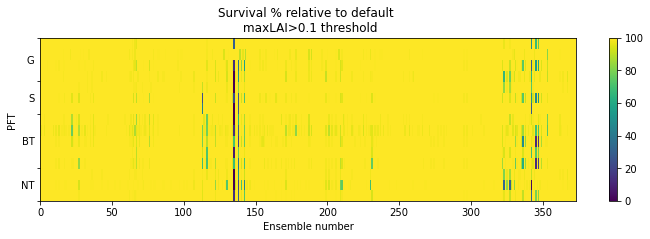

In [15]:
fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(surv.T,vmin=0,vmax=100)
plt.colorbar()
plt.title('Survival % relative to default \n maxLAI>'+str(thresh)+' threshold')
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

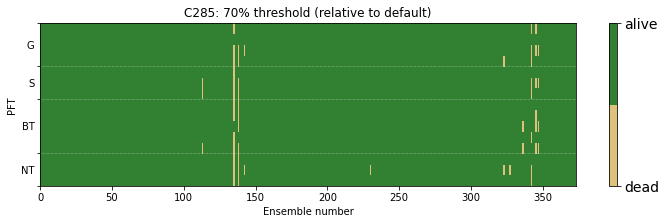

In [16]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)


fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(alive,cmap=newcmp)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=14) 
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
for y in [3,8,11]:
    plt.plot([0,len(ds.ens)],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title('C285: '+str(thresh)+'% threshold (relative to default)')
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

In [51]:
deads = dict()
for alive,ds in zip(alives,dsets):
    for i in alive.ens:
        if alive.isel(ens=i).sum()<15:
            p = ds.param[i].values
            m = ds.minmax[i].values
            k = str(ds.key[i].values)
            for f in alive.pft.values:
                if not alive.isel(ens=i).sel(pft=f):
                    if k in deads:
                        if f not in deads[k]:
                            deads[k].append(f)
                    else:
                        deads[k]=[f]


In [75]:
deads

{'OAAT0142': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  15.0],
 'OAAT0145': [2.0, 4.0, 7.0, 10.0, 12.0, 13.0, 1.0, 3.0, 6.0, 8.0, 9.0],
 'OAAT0149': [2.0, 13.0],
 'OAAT0350': [2.0, 12.0],
 'OAAT0354': [2.0],
 'OAAT0369': [1.0, 2.0, 9.0, 10.0, 13.0, 15.0, 5.0, 12.0],
 'OAAT0372': [4.0, 6.0, 10.0, 13.0, 7.0, 15.0],
 'OAAT0374': [4.0, 6.0, 10.0, 13.0],
 'OAAT0117': [10.0, 4.0, 9.0],
 'OAAT0410': [1.0, 2.0, 3.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0],
 'OAAT0416': [4.0, 6.0, 10.0, 13.0],
 'OAAT0417': [1.0, 2.0, 3.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0],
 'OAAT0418': [4.0, 6.0, 10.0, 13.0, 7.0, 15.0],
 'OAAT0419': [4.0, 6.0, 10.0, 13.0],
 'OAAT0245': [2.0],
 'OAAT0363': [4.0, 6.0],
 'OAAT0414': [2.0],
 'OAAT0415': [2.0],
 'OAAT0120': [4.0]}

In [76]:
for r in resubmits:
    if r in deads:
        print(r,'in deads')
    else:
        print(r,'not in')

OAAT0140 not in
OAAT0143 not in
OAAT0147 not in
OAAT0351 not in
OAAT0355 not in
OAAT0370 not in
OAAT0373 not in
OAAT0375 not in
OAAT0391 not in
OAAT0117 in deads
OAAT0142 in deads
OAAT0145 in deads
OAAT0149 in deads
OAAT0245 in deads
OAAT0350 in deads
OAAT0354 in deads
OAAT0363 in deads
OAAT0369 in deads
OAAT0372 in deads
OAAT0374 in deads
OAAT0120 in deads


In [77]:
for d in deads:
    if d in resubmits:
        print(d,'resubmitted')
    else:
        print(d,'not')

OAAT0142 resubmitted
OAAT0145 resubmitted
OAAT0149 resubmitted
OAAT0350 resubmitted
OAAT0354 resubmitted
OAAT0369 resubmitted
OAAT0372 resubmitted
OAAT0374 resubmitted
OAAT0117 resubmitted
OAAT0410 not
OAAT0416 not
OAAT0417 not
OAAT0418 not
OAAT0419 not
OAAT0245 resubmitted
OAAT0363 resubmitted
OAAT0414 not
OAAT0415 not
OAAT0120 resubmitted


In [70]:
laithresh=0.1

In [78]:
ds = dsets[2]
npix0=(ds.TLAI.isel(ens=0).max(dim='time')>laithresh).groupby('pft').sum().compute()
for i in 400+np.arange(1):
    k   = 'OAAT'+str(i).zfill(4)
    ix  = ds.key==k
    p   = ds.param[ix].values[0]
    m   = ds.minmax[ix].values[0][:3]
    ix2 = np.logical_and(ds.param==p,ds.minmax==m)
    k2  = ds.key[ix2].values[0]
    
    npix1=(ds.TLAI.isel(ens=ix).max(dim='time')>laithresh).groupby('pft').sum().values.ravel()
    npix2=(ds.TLAI.isel(ens=ix2).max(dim='time')>laithresh).groupby('pft').sum().values.ravel()
    
    
    print(k2)

OAAT0140


In [81]:
p

'kp25ratio'

In [79]:
npix0

<xarray.DataArray 'TLAI' (pft: 17)>
array([  0, 133, 134,  95, 117,  70, 109, 126,  96,   7, 148, 110, 110,
       228, 156, 279, 143])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 12.0 13.0 14.0 15.0 16.0

In [80]:
npix2

array([  0, 133, 134,  95, 117,  70, 109, 125,  97,   7, 148, 110, 110,
       228, 157, 279, 143])

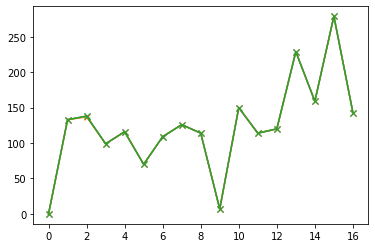

In [69]:
plt.plot(npix0,'-x')
plt.plot(npix1,'-x')
plt.plot(npix2,'-x')

In [42]:
deads

{'OAAT0142': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  15.0],
 'OAAT0145': [2.0, 4.0, 7.0, 10.0, 12.0, 13.0, 1.0, 3.0, 6.0, 8.0, 9.0],
 'OAAT0149': [2.0, 13.0],
 'OAAT0350': [2.0, 12.0],
 'OAAT0354': [2.0],
 'OAAT0369': [1.0, 2.0, 9.0, 10.0, 13.0, 15.0, 5.0, 12.0],
 'OAAT0372': [4.0, 6.0, 10.0, 13.0, 7.0, 15.0],
 'OAAT0374': [4.0, 6.0, 10.0, 13.0],
 'OAAT0117': [10.0, 4.0, 9.0],
 'OAAT0410': [1.0, 2.0, 3.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0],
 'OAAT0416': [4.0, 6.0, 10.0, 13.0],
 'OAAT0417': [1.0, 2.0, 3.0, 5.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0],
 'OAAT0418': [4.0, 6.0, 10.0, 13.0, 7.0, 15.0],
 'OAAT0419': [4.0, 6.0, 10.0, 13.0],
 'OAAT0245': [2.0],
 'OAAT0363': [4.0, 6.0],
 'OAAT0414': [2.0],
 'OAAT0415': [2.0],
 'OAAT0120': [4.0]}

In [21]:
for k in deads:
    ix    = paramkey.key==k
    param = paramkey.param[ix].values[0]
    print(k,param)

OAAT0140 kp25ratio
OAAT0143 slatop
OAAT0147 jmaxb1
OAAT0351 jmaxha
OAAT0355 lmrha
OAAT0370 lmrhd
OAAT0373 jmaxse_sf
OAAT0375 tpuse_sf
OAAT0391 slopebeta
OAAT0117 medlynslope
OAAT0142 lmrse
OAAT0145 jmaxb0
OAAT0149 wc2wjb0
OAAT0245 q10_mr
OAAT0350 vcmaxha
OAAT0354 tpuha
OAAT0363 vcmaxhd
OAAT0369 lmrhd
OAAT0372 vcmaxse_sf
OAAT0374 jmaxse_sf
OAAT0120 medlynintercept


In [17]:
p0 = xr.open_dataset('/glade/scratch/djk2120/PPEn11/paramfiles/OAAT0000.nc')

In [18]:
#instantiate the Ensemble object
basefile = '/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/ctsm51_params.c210507.nc'
lndin    = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
pdir     = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir     = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
nextnum  = 399
x        = Ensemble(basefile,pdir,ndir)


for k in deads:
    nextnum +=1
    newk  = 'OAAT'+str(nextnum).zfill(4)
    
    p     = xr.open_dataset('/glade/scratch/djk2120/PPEn11/paramfiles/'+k+'.nc')
    ix    = paramkey.key==k
    param = paramkey.param[ix].values[0]
    minmax = paramkey.minmax[ix].values[0]+'2'
    
    if param != 'KCN':
        if param in p.data_vars:
            loc    = 'P'
            defval = get_default(param, loc, p0, lndin)    
            nx     = p[param].shape

            if not nx:
                newx   = 0.5*(p0[param]+p[param]).values
            else:
                newx = p[param].copy(deep=True).values
                for f in deads[k]:
                    f       = int(f)
                    newx[f] = 0.5*(p[param][f]+p0[param][f])

            value  = parse_val(loc,defval,newx)
        else:
            loc    = 'N'
            nfile  = '/glade/scratch/djk2120/PPEn11/namelist_mods/'+k+'.txt'
            cmd = 'grep '+param+' '+nfile
            tmp = os.popen(cmd).read()
            defval = get_default(param, loc, p0, lndin)
            x0     = float(tmp.split('=')[1].split('\n')[0])
            newx   = 0.5*(defval+x0) 
            value  = parse_val(loc,defval,newx)

        print(newk,param,loc,defval,value)
        paraminfo = ParamInfo(param, loc, defval, value)
        paramdict = {param:paraminfo}
        member = Member(newk,paramdict,basefile,minmax)   
        x.add_member(member)

OAAT0400 kp25ratio P 20000.0 40000.0
OAAT0401 slatop P [0.      0.01    0.01    0.02018 0.019   0.019   0.0308  0.0308  0.0308
 0.01798 0.03072 0.028   0.021   0.04024 0.03846 0.04024 0.04024 0.05
 0.05    0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035
 0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035
 0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035
 0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035
 0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035   0.035
 0.035   0.035   0.035   0.035   0.05    0.05    0.035   0.035   0.035
 0.035   0.035   0.035   0.05    0.05    0.035   0.035  ] [0.      0.0073  0.00865 0.0177  0.0174  0.0158  0.0278  0.0293  0.0278
 0.0147  0.02921 0.0248  0.0194  0.03867 0.0351  0.0371  0.0371  0.0371
 0.0371  0.0371  0.0371  0.0371  0.0371  0.0371  0.0371  0.0371  0.0371
 0.0371  0.0371  0.0371  0.0371  0.0371  0.0371  0.0371  0.0371  0.0371
 0.0371  0.0371  0.0371  0.0371

In [19]:
csvfile='/glade/scratch/djk2120/PPEn11/resubmission_071221.csv'
x.write(csvfile=csvfile)


In [84]:
newx

0.11000000000000001

In [80]:
x0

'0.05'

In [54]:
cmd = 'grep '+param+' '+lndin

In [56]:
deads['a'].append(2)

In [57]:
deads['a']

[1, 2]

In [31]:
alive.pft.values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15.])

In [21]:
resubmits = alive.isel(ens=ix)
    

<xarray.DataArray 'TLAI' (pft: 15, ens: 11)>
array([[ True, False, False,  True,  True,  True,  True,  True, False,
         True,  True],
       [ True, False, False, False, False, False, False,  True, False,
         True,  True],
       [ True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True],
       [False, False, False,  True,  True,  True,  True, False,  True,
        False, False],
       [ True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True],
       [ True,  True, False,  True,  True,  True,  True, False,  True,
        False, False],
       [ True, False, False,  True,  True,  True,  True,  True,  True,
        False,  True],
       [ True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True],
       [False, False, False,  True,  True,  True,  True,  True, False,
         True,  True],
       [False, False, False,  True,  True,  True,  True,  True, False,
        False, False],
       [ True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True, False, False,  True,  True, False,  True,  True, False,
         True,  True],
       [ True, False, False, False,  True,  True,  True,  True, False,
        False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True, False,
        False,  True]])
Coordinates:
  * pft      (pft) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 11.0 12.0 13.0 14.0 15.0
Dimensions without coordinates: ens

### AF1905

In [21]:
ds = get_ensemble('AF1905',['TLAI','GPP'],'h1',paramkey)
#reassign pft variable for easier analysis
afile = '/glade/scratch/djk2120/PPEn11/hist/C285/PPEn11_C285_OAAT0398.clm2.h1.2005-02-01-00000.nc'
tmp = xr.open_dataset(afile)
ds['pft']=tmp['pfts1d_itype_veg'] 

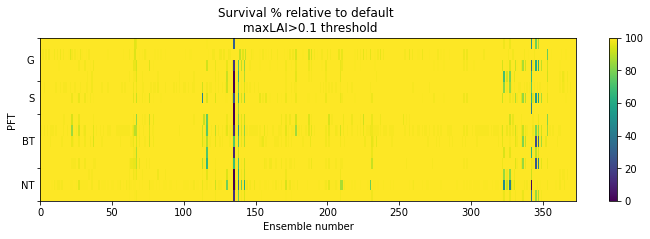

In [22]:
thresh  = 0.1
npixels = (ds['TLAI'].max(dim='time')>thresh).groupby('pft').sum().compute()
surv    = 100*npixels/npixels.isel(ens=0).compute().isel(pft=1+np.arange(15))

fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(surv.T,vmin=0,vmax=100)
plt.colorbar()
plt.title('Survival % relative to default \n maxLAI>'+str(thresh)+' threshold')
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

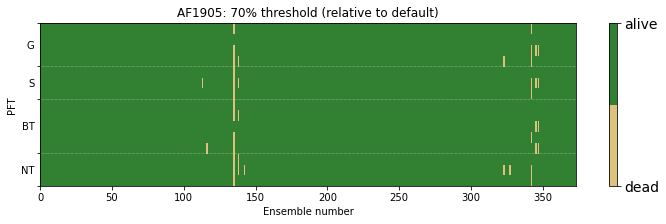

In [25]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)

thresh = 70
alive = surv.T>thresh
fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(alive,cmap=newcmp)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=14) 
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
for y in [3,8,11]:
    plt.plot([0,len(ds.ens)],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title('AF1905: '+str(thresh)+'% threshold (relative to default)')
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

In [24]:
ix     = alive.sum(dim='pft')<15
ndeads = 15-alive.sum(dim='pft').values[ix]
for p,m,nd in zip(ds.param[ix].values,ds.minmax[ix].values,ndeads):
    print(p+'-'+m+': '+str(nd)+' PFTs dead')

medlynslope-min: 1 PFTs dead
medlynintercept-max: 1 PFTs dead
lmrse-max: 13 PFTs dead
jmaxb0-min: 5 PFTs dead
wc2wjb0-min: 1 PFTs dead
vcmaxha-max: 2 PFTs dead
tpuha-max: 1 PFTs dead
lmrhd-min: 8 PFTs dead
vcmaxse_sf-max: 4 PFTs dead
jmaxse_sf-max: 4 PFTs dead


### CTL2010

In [27]:
ds = get_ensemble('CTL2010',['TLAI','GPP'],'h1',paramkey)
#reassign pft variable for easier analysis
afile = '/glade/scratch/djk2120/PPEn11/hist/C285/PPEn11_C285_OAAT0398.clm2.h1.2005-02-01-00000.nc'
tmp = xr.open_dataset(afile)
ds['pft']=tmp['pfts1d_itype_veg'] 

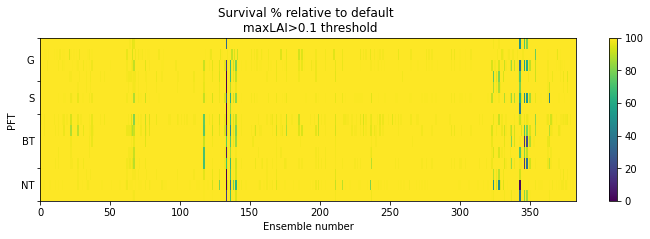

In [28]:
thresh  = 0.1
npixels = (ds['TLAI'].max(dim='time')>thresh).groupby('pft').sum().compute()
surv    = 100*npixels/npixels.isel(ens=0).compute().isel(pft=1+np.arange(15))

fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(surv.T,vmin=0,vmax=100)
plt.colorbar()
plt.title('Survival % relative to default \n maxLAI>'+str(thresh)+' threshold')
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

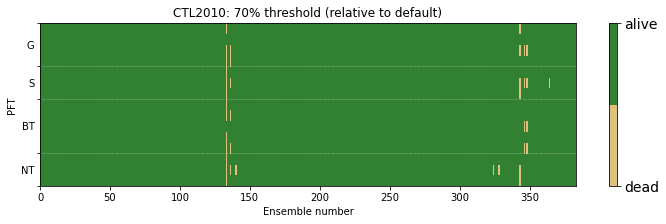

In [29]:
vals = np.ones([2,4])
vals[0,:3]=np.array([223,194,125])/256
vals[1,:3]=np.array([50,130,50])/256
newcmp = matplotlib.colors.ListedColormap(vals)

thresh = 70
alive = surv.T>thresh
fig,ax = plt.subplots(figsize=[12,3])
plt.pcolormesh(alive,cmap=newcmp)

cbar=plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['dead', 'alive']) 
cbar.ax.tick_params(labelsize=14) 
plt.yticks([0,3,8,11,15])
ax.set_yticks([1.5,5.5,9.5,13], minor=True)
for y in [3,8,11]:
    plt.plot([0,len(ds.ens)],[y,y],':',color=[0.9,0.9,0.9],linewidth=0.5)

ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticklabels(['NT','BT','S','G'],minor=True)
for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
plt.title('CTL2010: '+str(thresh)+'% threshold (relative to default)')
plt.ylabel('PFT')
plt.xlabel('Ensemble number');

In [30]:
ix     = alive.sum(dim='pft')<15
ndeads = 15-alive.sum(dim='pft').values[ix]
for p,m,nd in zip(ds.param[ix].values,ds.minmax[ix].values,ndeads):
    print(p+'-'+m+': '+str(nd)+' PFTs dead')

lmrse-max: 13 PFTs dead
jmaxb0-min: 6 PFTs dead
wc2wjb0-min: 1 PFTs dead
vcmaxha-max: 1 PFTs dead
tpuha-max: 1 PFTs dead
lmrhd-min: 6 PFTs dead
vcmaxse_sf-max: 4 PFTs dead
jmaxse_sf-max: 4 PFTs dead
medlynslope-min: 1 PFTs dead
